# **Smart-UJ UAQUE**
Este Notebook hace parte del servicio inteligente "perfil grupal" y tiene como principal objetivo la generación de grupos a partir de las carácteristicas de los usuarios, incluyendo sus gustos y preferencias de lectura obtenidos a partir del historial de prestamos de material bibliográfico físico en la biblioteca Alfonso Borrero Cabal S.J.

Para formar estos grupos se realizarán varios acercamientos con diferentes técnicas, algóritmos y aproximaciones a partir de los modelos de recomendación clásicos. Posteriormente, se escogerá el mejor modelo para el sistema de recomendación y los grupos serán exportados al servicio inteligente "Servicio de recomedación UAQUE".

**Integrantes:**</br>
Johan Ortegón </br>
Juan Angarita </br>
Jorge Salgado </br>
Daniel Tibaquira </br></br>
**Directora de Proyecto de Grado:** </br>
Viky Arias </br>


#Importación de datos

# Primero importamos el drive para poder leer los archivos

Estas son las librerias que vamos a usar para hacer el join de ambas tablas y poder hacer las diferentes agrupaciones de estudiantes. 

* pandas(pd): Permite almacenar los datos en dataframes(matrices) y operación entre las celdas.

# Construir la tabla de pesos Dewey por usuario con Cluster

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

# Usando el modelo ya existente

In [11]:
df = pd.read_json('../data/Join/JoinTablas.json')
# coll_tem = input('Ingrese la columna con la tematica del material: ')

Anotamos la estructura del archivo. 

In [12]:
print("Numero de filas:", df.shape[0])
print("Numero de columnas:", df.shape[1])

Numero de filas: 489474
Numero de columnas: 20


El clustering para este experimento se realizará sobre el atributo "Signatura" el cual representa el dewey hasta la unidad (dando aproximadamente 900 deweys diferentes). Recordar la diferencia entre la columna "Dewey" y "Signatura". La primera es la que originalmente contiene el dataset de prestamos y solo venía con valores hasta la decena, mientras que "Sginatura" originalmente era una valor que señalaba el dewey especifico del libro y su ubicación al interior de la biblioteca. Se realizo una transformación para obtener únicamente el valor númerico de este valor y así obtener el dewey hasta la unidad(más especifico).

In [13]:
eliminar = df.loc[df["Signatura"].isnull()]
print("Numero de datos sin Dewey(Singatura):" , eliminar.shape[0])

Numero de datos sin Dewey(Singatura): 0


In [14]:
print("Valores de signatura unicos: " , len(df["Signatura"].unique()))
print("Valores de Dewey(decena) unicos: " , len(df["Dewey"].unique()))

Valores de signatura unicos:  756
Valores de Dewey(decena) unicos:  99


A partir del análisis con expertos en negocio, se ha entendido que es importante tomar en cuenta el cambio de gustos de los usuarios a través del tiempo y dar menos peso a prestamos que se realizaron en el pasado a prestamos más recientes. Para esto se creará una nueva columna denominada "Peso" la cual determinará el peso quue tiene dicho prestamo.
La disminución del peso será exponencial según la diferencia con el año actual y se calculará con la siguiente formula:

$Peso = \frac{1}{2^{(2021-20xx)}}$


In [15]:
df["Peso"] = df.apply(lambda row: 1/2**(2021-row.Year), axis=1 )

In [16]:
df.columns

Index(['RowID', 'Fecha', 'IDItem', 'NumeroUbicacion', 'Dewey', 'Ubicacion',
       'Llave', 'Programa', 'Facultad', 'IDUsuario', 'Year', 'Signatura',
       'TipoItem', 'Autor', 'Titulo', 'AnioPublicacion', 'DeweyEspecifico',
       'TemaDewey', 'Temas', 'Union', 'Peso'],
      dtype='object')

Se creará una nueva tabla donde únicamente se van a tener en cuenta los deweys que le gustan a cada usuario así como los atributos para posteriormente realizar el clustering. 

In [17]:
pesos_usuarios = pd.DataFrame(columns= df["Signatura"].unique(),dtype=float)
tam = len(df["Signatura"].unique())
pesos_usuarios.columns = pesos_usuarios.columns.astype(str)
display(pesos_usuarios)

ids = df["IDUsuario"].unique()
i = 0
for usuario in ids:
  pesos_usuarios.loc[i] = np.zeros((tam,), dtype=int)
  #Para cada usuario traer sus Deweys y sus pesas asociados
  prestamos = df.loc[df["IDUsuario"]==usuario]
  deweys = prestamos[["Signatura","Peso"]]
  result_user = deweys.groupby("Signatura")["Peso"].sum().reset_index(name="Peso")
  # Recorrer los Deweys y Pesos para plasmarlos en una matriz
  #display(result_user)
  for index, row in result_user.iterrows():
    d = row["Signatura"]
    p=row['Peso']
    pesos_usuarios[d][i] = p
  i = i+1

,720,540,512,712,741,814,823,330,863,696,...,267,114,034,673,447,600,653,263,091,586


La matriz generada es una matriz dispersa donde todos los valores son ceros excepto donde el usuario haya realizado un prestamo.

In [18]:
pesos_usuarios.shape

(24407, 756)

# Configuración Modelos
A partir del archivo "Comparación modelos" se puede concluir que el modelo que ayuda en mayor medida a agrupar los datos, minimizando el número de clusters con tamaño menor a 20 y la desviación estandar es kmeans con los siguiente parámetros:
* Filas normalizadas = true
* Columnas normalizadas = true
* PCA = 0.95
* Número de clusters = 150
* Número de iteraciones = 500

In [19]:
resumen = pd.DataFrame(columns = ["Tecnica","PCA", "Norm_filas", "Norm_col", "Precision", "Desviacion_estandar", "Media", "Coeficiente_variacion", "Clusters","Grupo_mas_grande", "Grupos<10", "Grupos<20"])


In [20]:
def std_dev_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.std(sizes_labels)

In [21]:
def mean_cluster(data, labs):
    sizes_labels = []
    for label in np.unique(labs):
        sizes_labels.append(len(data.loc[data["cluster"] == label]))
    
    return np.mean(sizes_labels)

In [22]:
#
PCA = 0.95
num_clusters = 150
num_iter = 30

# Algoritmo kmeans

In [23]:
final = pesos_usuarios

In [24]:
##Exportamos los datos del modelo que nos dio mejores resultados
#Normalización
#2.5 min por iteración
sumatoria = final.sum(axis=1)
pesos_norm = final.div(sumatoria, axis=0).fillna(0)

scaler = MinMaxScaler()
pesos_norm = scaler.fit_transform(pesos_norm.values)

  #Kmeans
k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = num_iter)
k_means.fit_predict(pesos_norm)
labels = k_means.labels_

In [25]:
df2 = pesos_usuarios.copy()
df2["cluster"] = labels
df2["IDUsuarios"] = ids
display(df2)

,720,540,512,712,741,814,823,330,863,696,...,034,673,447,600,653,263,091,586,cluster,IDUsuarios
0,2.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,108,c361c772cd0220bb16dcfb2ad803e4903334ab94
1,0.00,1.0,1.25,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,56,87b0e5a61ed712ddfaf5d478ad68c87c825997e9
2,0.00,0.0,0.00,3.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,56,afe8c17ba351d274fc5671978918f0c93032d88f
3,0.25,0.0,0.00,0.000,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,119,6b39c8ff51a36458e3f68233b82c1ce8bd8cc3d3
4,5.00,0.0,0.00,0.875,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,108,a8cd77c9b47b2723fbd8013ce467664f93ad73e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24402,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,21,a08277a9db1e5cbcac98ca5707a343fce0a8128a
24403,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,122,2af3b662cce52945aeec54a03152892f15190444
24404,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,56,ea28f5400ec4129b4e3f4a96bc423491043773b5
24405,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,21,ba922689e879575fd992d1d92e7dd194d3efdcc7


# Exportar datos

Exportar la tabla con los Deweys por Usuario con su cluster para ser usada por el dashboard a continuación.

In [26]:
df2.to_json('../Dashboard/pesos_usuario_dewey_unidad.json')

# Importando los datos necesario para producir el DashBoard

In [42]:
pesosUsuarios = pd.read_json('../Dashboard/pesos_usuario_dewey_unidad.json')
clusterCentroides = pd.read_json('../Data/GruposDeweyUnidad/centroids.json')

In [43]:
display(pesosUsuarios)
display(clusterCentroides)

,720,540,512,712,741,814,823,330,863,696,...,034,673,447,600,653,263,091,586,cluster,IDUsuarios
0,2.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,108,c361c772cd0220bb16dcfb2ad803e4903334ab94
1,0.00,1.0,1.25,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,56,87b0e5a61ed712ddfaf5d478ad68c87c825997e9
2,0.00,0.0,0.00,3.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,56,afe8c17ba351d274fc5671978918f0c93032d88f
3,0.25,0.0,0.00,0.000,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,119,6b39c8ff51a36458e3f68233b82c1ce8bd8cc3d3
4,5.00,0.0,0.00,0.875,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,108,a8cd77c9b47b2723fbd8013ce467664f93ad73e6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24402,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,21,a08277a9db1e5cbcac98ca5707a343fce0a8128a
24403,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,122,2af3b662cce52945aeec54a03152892f15190444
24404,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,56,ea28f5400ec4129b4e3f4a96bc423491043773b5
24405,0.00,0.0,0.00,0.000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,21,ba922689e879575fd992d1d92e7dd194d3efdcc7


,720,540,512,712,741,814,823,330,863,696,...,267,114,034,673,447,600,653,263,091,586
0,0.891100,0.000000,0.000000,0.006855,0.000758,0.000000,0.000631,0.000000,0.000140,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.007524,0.000019,0.001273,0.001755,0.325837,0.002025,0.016767,0.006725,0.033209,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001903,0.000000,0.001907,0.000000,0.007182,0.000442,0.002778,0.023522,0.009621,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.002262,0.000952,0.000000,0.000000,0.863419,0.000000,0.005357,0.000794,0.003828,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000994,0.000236,0.005798,0.000250,0.005909,0.002447,0.006718,0.108800,0.017449,0.000099,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.004084,0.000423,0.006029,0.000402,0.007969,0.001233,0.008632,0.016815,0.020695,0.000451,...,0.0,0.0,0.0,0.00202,0.0,0.0,0.0,0.0,0.0,0.0
146,0.000000,0.000000,0.009259,0.000000,0.000000,0.000000,0.000000,0.009656,0.001989,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
147,0.005995,0.000437,0.000000,0.001390,0.003390,0.000688,0.004602,0.010897,0.017072,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
148,0.000000,0.000000,0.000153,0.000000,0.017500,0.000000,0.000000,0.002273,0.001344,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


# Centroides por cluster

In [36]:
'''centroids = k_means.cluster_centers_
print('Num clusters:', len(centroids))
print('Num Deweys', len(centroids[5]))
display(centroids[5])

# De centroides negativos a 0
for i in range(len(centroids)):
  for j in range(len(centroids[0])-1):
    if centroids[i][j] < 0:
      centroids[i][j] = 0

df_centroids = pd.DataFrame(centroids, columns = df2.columns[:len(df2.columns)-2])
'''

df_centroids["Sum"] = df_centroids.sum(axis = 1)
display(df_centroids)

temp_matrix = df_centroids.to_numpy()

for i in range(len(temp_matrix)):
  for j in range(len(temp_matrix[0]) - 1):
    if temp_matrix[i][len(temp_matrix[0]) - 1] > 0:
      temp_matrix[i][j] = temp_matrix[i][j] * 100
df_centroids_porcentaje = pd.DataFrame(temp_matrix, columns=df_centroids.columns)
display(df_centroids_porcentaje)


Num clusters: 150
Num Deweys 756


array([ 1.52462266e-04, -1.95156391e-18,  2.13447172e-04, -8.67361738e-19,
        1.30700487e-04, -1.95156391e-18,  3.55171924e-04,  1.24269787e-03,
        3.60827362e-04, -7.58941521e-19,  2.49021700e-04,  1.08420217e-18,
        5.19373097e-04,  7.58941521e-19,  0.00000000e+00,  3.49816198e-04,
       -7.37257477e-18,  2.13447172e-04,  7.62311328e-05,  1.82954719e-05,
        1.35460413e-04,  5.63785130e-18,  1.84314369e-18,  6.89256492e-04,
       -8.67361738e-19,  3.40754837e-04,  2.16840434e-18, -1.95156391e-18,
        1.27649779e-04,  4.43308230e-04,  3.85905802e-04,  2.03283021e-04,
        9.70214417e-05,  2.60208521e-17, -2.60208521e-18, -3.68628739e-18,
        2.20562078e-04,  1.47451495e-17,  2.22340804e-05,  1.11170402e-05,
        4.33680869e-19,  3.25260652e-19, -2.38524478e-18, -6.50521303e-18,
        2.43939625e-05,  3.04924531e-05,  3.81155664e-04, -4.55364912e-18,
        9.81482619e-01,  1.93509799e-04, -2.16840434e-19,  4.55364912e-18,
        5.42101086e-19, -

,720,540,512,712,741,814,823,330,863,696,...,114,034,673,447,600,653,263,091,586,Sum
0,1.734723e-18,1.084202e-18,8.673617e-19,0.000000,0.000000e+00,2.018978e-04,3.469447e-18,0.000000,0.001125,0.000000e+00,...,0.000000e+00,1.355253e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.032879e-20,1.000505
1,4.508567e-03,0.000000e+00,1.348192e-04,0.002122,1.280962e-02,4.798969e-03,3.453775e-03,0.002548,0.015175,2.168404e-19,...,2.710505e-20,0.000000e+00,2.032879e-20,1.355253e-20,2.032879e-20,2.032879e-20,2.032879e-20,2.032879e-20,2.032879e-20,1.028143
2,4.276394e-03,4.164931e-04,4.721380e-05,0.000023,4.854465e-03,1.429812e-03,1.198724e-02,0.005197,0.023440,6.137793e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.355253e-20,1.025783
3,5.122189e-03,3.787879e-04,6.106404e-05,0.000735,3.014654e-03,2.168404e-19,8.054218e-03,0.017907,0.012523,0.000000e+00,...,0.000000e+00,1.355253e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.032879e-20,1.031029
4,0.000000e+00,4.336809e-19,0.000000e+00,0.000000,3.469447e-18,0.000000e+00,6.912766e-04,0.000000,0.000113,0.000000e+00,...,6.776264e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.776264e-21,1.000333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.000000e+00,0.000000e+00,4.336809e-19,0.000000,4.229747e-03,3.418803e-04,4.340786e-03,0.000000,0.008846,2.168404e-19,...,0.000000e+00,1.355253e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.020187
146,6.938894e-18,3.639847e-03,4.105090e-04,0.002024,5.237170e-03,1.915709e-03,4.701407e-03,0.004857,0.006424,4.420866e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.032879e-20,1.013504
147,0.000000e+00,0.000000e+00,1.515152e-02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.003788,0.000000,1.084202e-19,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.007576
148,0.000000e+00,2.168404e-19,4.336809e-19,0.000000,0.000000e+00,3.378378e-03,5.159705e-03,0.001638,0.000000,1.084202e-19,...,0.000000e+00,1.355253e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.776264e-21,1.000832


,720,540,512,712,741,814,823,330,863,696,...,114,034,673,447,600,653,263,091,586,Sum
0,1.734723e-16,1.084202e-16,8.673617e-17,0.000000,0.000000e+00,2.018978e-02,3.469447e-16,0.000000,0.112486,0.000000e+00,...,0.000000e+00,1.355253e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.032879e-18,1.000505
1,4.508567e-01,0.000000e+00,1.348192e-02,0.212198,1.280962e+00,4.798969e-01,3.453775e-01,0.254820,1.517525,2.168404e-17,...,2.710505e-18,0.000000e+00,2.032879e-18,1.355253e-18,2.032879e-18,2.032879e-18,2.032879e-18,2.032879e-18,2.032879e-18,1.028143
2,4.276394e-01,4.164931e-02,4.721380e-03,0.002332,4.854465e-01,1.429812e-01,1.198724e+00,0.519734,2.344032,6.137793e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.355253e-18,1.025783
3,5.122189e-01,3.787879e-02,6.106404e-03,0.073462,3.014654e-01,2.168404e-17,8.054218e-01,1.790744,1.252265,0.000000e+00,...,0.000000e+00,1.355253e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.032879e-18,1.031029
4,0.000000e+00,4.336809e-17,0.000000e+00,0.000000,3.469447e-16,0.000000e+00,6.912766e-02,0.000000,0.011292,0.000000e+00,...,6.776264e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.776264e-19,1.000333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.000000e+00,0.000000e+00,4.336809e-17,0.000000,4.229747e-01,3.418803e-02,4.340786e-01,0.000000,0.884607,2.168404e-17,...,0.000000e+00,1.355253e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.020187
146,6.938894e-16,3.639847e-01,4.105090e-02,0.202419,5.237170e-01,1.915709e-01,4.701407e-01,0.485684,0.642392,4.420866e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.032879e-18,1.013504
147,0.000000e+00,0.000000e+00,1.515152e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.378788,0.000000,1.084202e-17,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.007576
148,0.000000e+00,2.168404e-17,4.336809e-17,0.000000,0.000000e+00,3.378378e-01,5.159705e-01,0.163800,0.000000,1.084202e-17,...,0.000000e+00,1.355253e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.776264e-19,1.000832


In [91]:
dfp = df2.loc[df2['cluster'] == 5]
#print(len(dfp))
#display(dfp)
dfp.loc[dfp['350'] > 0]

df2_copy = df2.iloc[: , : -3]
df2_copy["Sum"] = df2_copy.sum(axis = 1)

df2_total = df2
df2_total['Total'] = df2_copy["Sum"]

df2_porcentaje = df2_total
num_columns = len(df2_porcentaje.columns) - 3
#print(df2_porcentaje.iloc[0]["Total"])

temp_matrix = df2_porcentaje.to_numpy()

for i in range(len(df2_porcentaje)):
  for j in range(num_columns):
    if temp_matrix[i][len(temp_matrix[0]) - 1] > 0:
      temp_matrix[i][j] = (temp_matrix[i][j]*100) / temp_matrix[i][len(temp_matrix[0]) - 1]

df2_porcentaje = pd.DataFrame(temp_matrix, columns=df2_porcentaje.columns)
display(df2_porcentaje)



,720,540,510,710,740,810,820,330,860,690,620,150,940,570,840,800,Tesis,300,350,380,130,Mapa,340,980,Revista,Video,700,360,920,750,890,420,650,780,0,910,680,120,370,610,...,440,20,250,660,760,170,600,230,140,390,180,270,870,430,100,10,160,220,210,Diapositiva,470,400,460,60,200,480,960,310,280,None,Tablet,50,90,Juego,30,Video Juego,Interbibliotecario,cluster,ids usuarios,Total
0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,c361c772cd0220bb16dcfb2ad803e4903334ab94,2.5
1,9.09091,18.1818,22.7273,0,0,9.09091,0,0,0,0,0,0,0,0,0,0,0,4.54545,0,0,0,0,18.1818,0,0,0,0,13.6364,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,137,87b0e5a61ed712ddfaf5d478ad68c87c825997e9,5.5
2,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,afe8c17ba351d274fc5671978918f0c93032d88f,3
3,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,6b39c8ff51a36458e3f68233b82c1ce8bd8cc3d3,0.25
4,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,a8cd77c9b47b2723fbd8013ce467664f93ad73e6,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,20,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,73,da2055e503d6e3c162ed8708b15235807abd9547,15
17230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.3333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,33.3333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,0506de90d38f6562213fb9239dd2e0c32ced2869,6
17231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,18049306edc70474f62da968b2bb8e8fe496a2ca,1
17232,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.1818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18.1818,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,23fa3196e4b1917467e020242458e497be14ae20,11


107
107
720            3.708723e-01
540            5.204170e-16
510            4.201321e-01
710            0.000000e+00
740            3.964365e-01
                   ...     
50             0.000000e+00
90             1.355253e-18
Juego          0.000000e+00
30             0.000000e+00
Video Juego    6.776264e-18
Name: 5, Length: 107, dtype: float64


Text(0.5, 0, 'Dewey')

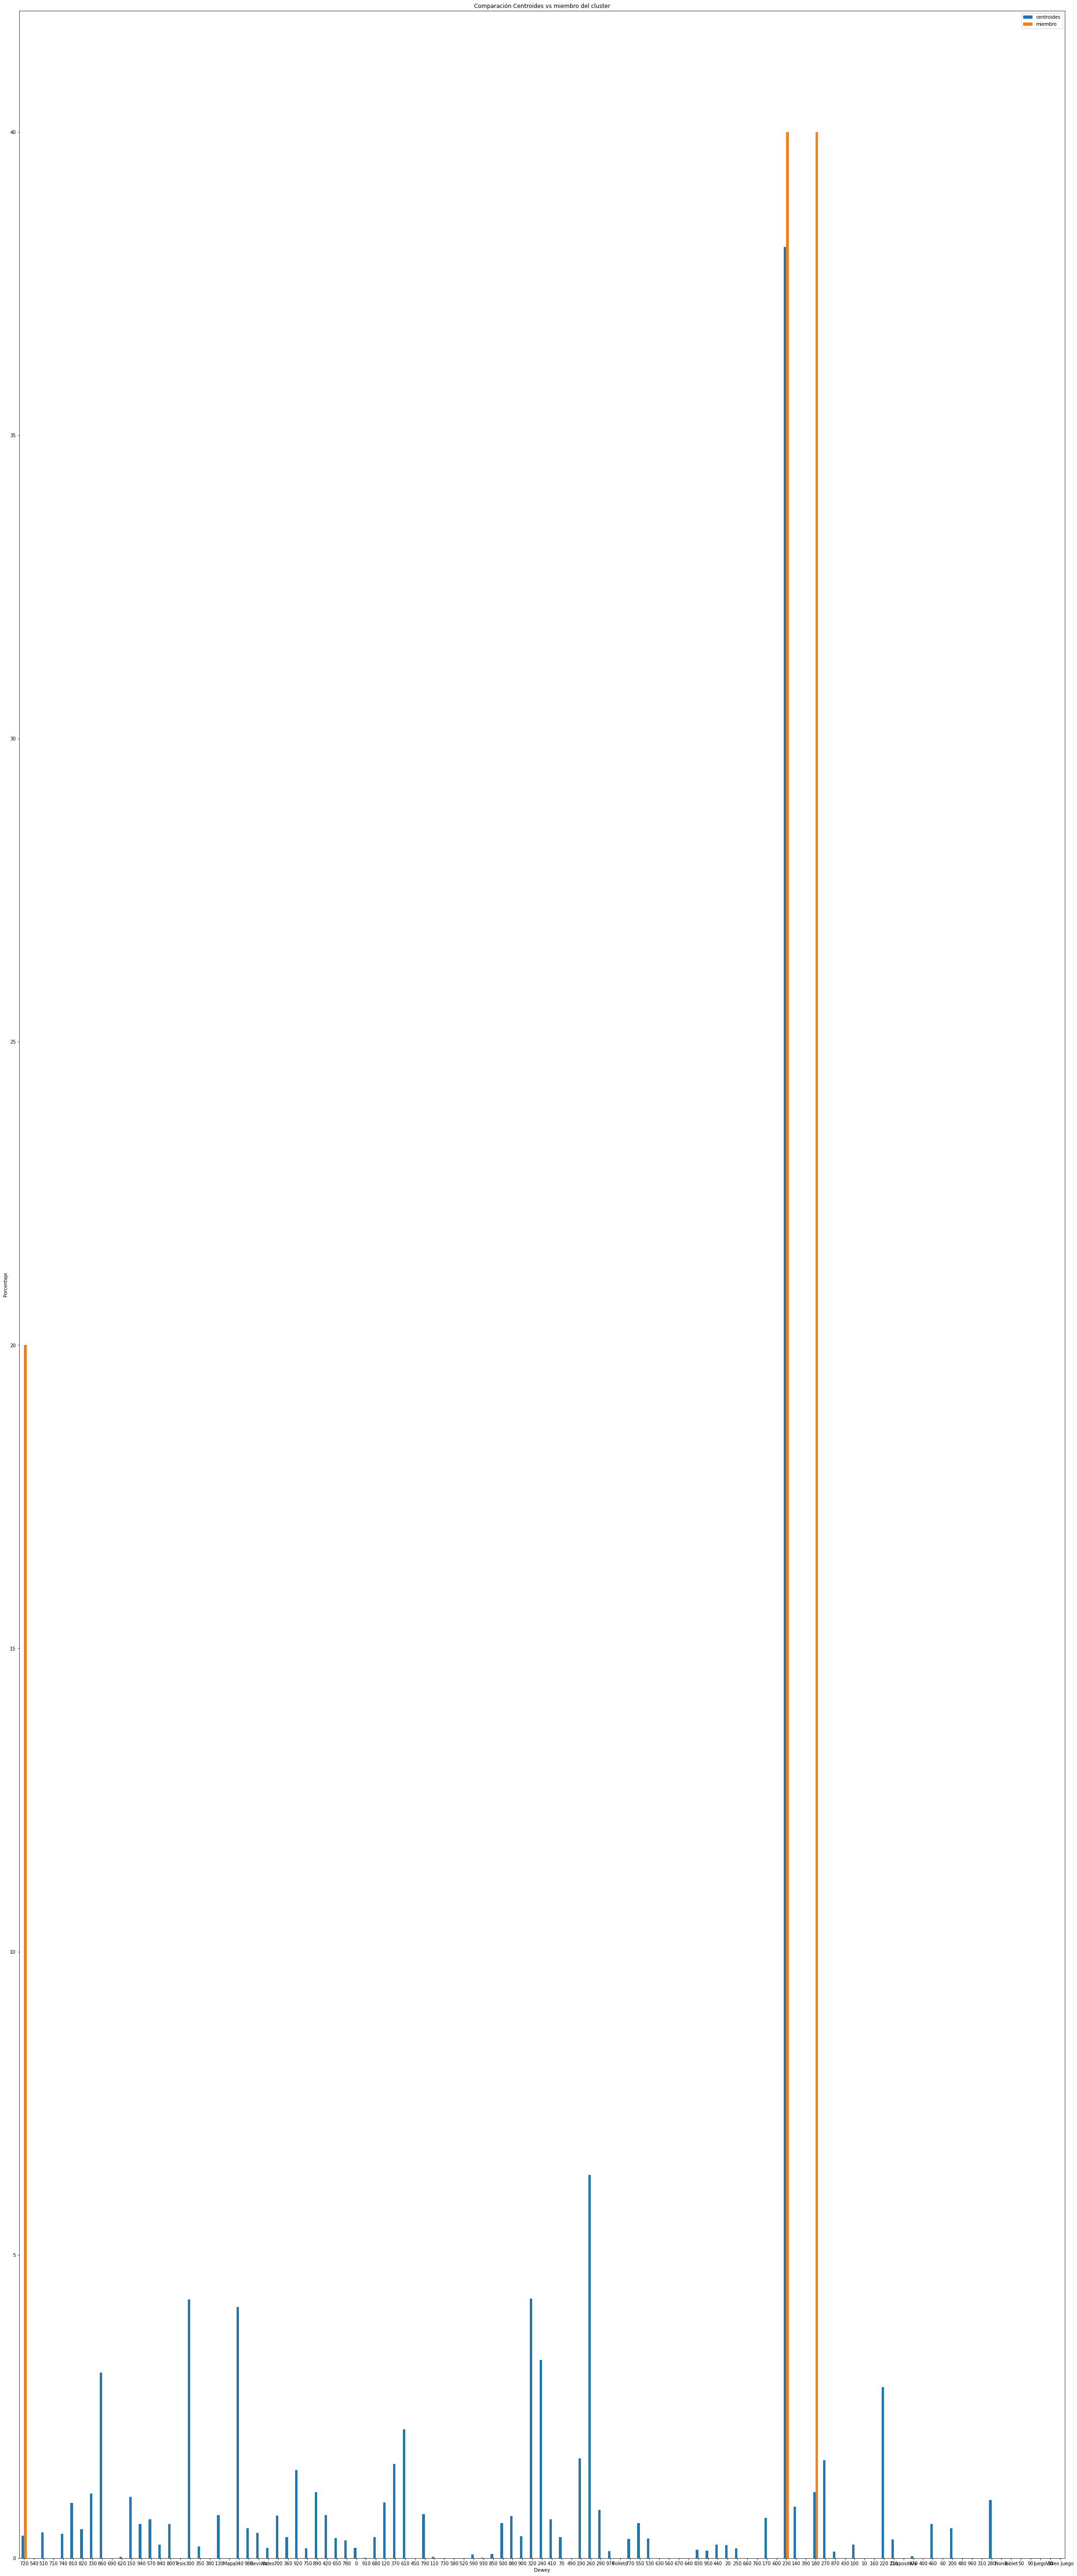

In [92]:
import matplotlib.pyplot as plt
labels = df_centroids.columns[:len(df_centroids.columns)-2]

print(len(df_centroids_porcentaje.columns)-2)
print(len(df2_porcentaje.columns)-4)

#Datos de los centroides de un cluster (%)
temp_centroids = df_centroids_porcentaje.iloc[5][:len(df_centroids_porcentaje.columns) - 2]
print(temp_centroids)

#Datos del primer miembro del cluster anterior (%)
temp_miembro = df2_porcentaje.loc[df2_porcentaje['cluster'] == 5].iloc[0][:len(df2_porcentaje.columns) - 4]

index = df_centroids_porcentaje.columns[:len(df_centroids_porcentaje.columns) - 2]

df_plot = pd.DataFrame({'centroides':temp_centroids, 'miembro':temp_miembro}, index=index)

ax = df_plot.plot.bar(rot=0, figsize=(40, 100), title="Comparación Centroides vs miembro del cluster")
ax.set_ylabel('Porcentaje')
ax.set_xlabel("Dewey")